# Chest X-Ray Images (Pneumonia)

这是一个胸部X光图像分类的项目，项目来自于 kaggle 的 [Chest X-Ray Images ](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)。<br>
数据选自广州市一家儿童医院一至五岁儿科患者（肺炎）胸部X光图像。<br>
本文是希望通过给定人工鉴定的训练集来拟合一个能够正确分类正常和肺炎患者的模型。<br>
<br>
Let's start.

### Import Modules

In [1]:
from pathlib import Path
import shutil
import numpy as np
import pandas as pd
from math import ceil

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import load_model

from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,precision_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load Data

让我们先浏览下数据

In [2]:
## 原始数据目录
raw_data_dir = Path('H:/kaggle/chest_xray')
raw_train_dir = raw_data_dir / 'train'
raw_val_dir = raw_data_dir / 'val'
raw_test_dir = raw_data_dir / 'test'

def look_data(path):
    """
    查看 train | val | test 文件夹下的 jpeg 格式的数据；
    以 DataFrame 的格式返回，默认索引；
    标签'image'为每张图片的绝对路径；
    标签'lable'为每张图片的类别，0 代表 NORMAL，1 代表 PNEUMONIA。
    """ 
    normal_cases_dir = path / 'NORMAL'
    pneumonia_cases_dir = path / 'PNEUMONIA'    
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

    data = []
    for img in normal_cases:
        data.append((img, 0))    
    for img in pneumonia_cases:
        data.append((img, 1))
    data = pd.DataFrame(data, columns=['image', 'label'])
    
    return data

raw_train = look_data(raw_train_dir)
raw_train.head()

image  label
0  H:\kaggle\chest_xray\train\NORMAL\IM-0115-0001...      0
1  H:\kaggle\chest_xray\train\NORMAL\IM-0117-0001...      0
2  H:\kaggle\chest_xray\train\NORMAL\IM-0119-0001...      0
3  H:\kaggle\chest_xray\train\NORMAL\IM-0122-0001...      0
4  H:\kaggle\chest_xray\train\NORMAL\IM-0125-0001...      0

In [3]:
print("Train Data:")
raw_train['label'].value_counts()

Train Data:


1    3875
0    1341
Name: label, dtype: int64

In [4]:
raw_val = look_data(raw_val_dir)
print("Val Data:")
raw_val['label'].value_counts()

Val Data:


1    8
0    8
Name: label, dtype: int64

In [5]:
raw_test = look_data(raw_test_dir)
print("Test Data:")
raw_test['label'].value_counts()

Test Data:


1    390
0    234
Name: label, dtype: int64

训练集一个 5216 个样本，其中正反例样本比例大概为 3:1。
验证集只有 16 个样本。
测试集有 624 个样本。<br>
这里验证集和训练集的数量差别很大，这将会使模型的验证准确性下降。我们需要重新分配下训练集和验证集的比例。

### Shuffle and Divide

我们把训练集和验证集重新分配为8:2的比例。<br>
因为没有额外的标签集，所以我们创建新的训练和验证目录，这样方便后面的训练。

In [8]:
def shuffle_data(seed=41):
    """
    测试集和验证集样本合并，然后洗牌。
    """
    total_data = pd.DataFrame(columns=['image', 'label'])
    for pdir in ['train', 'val']:
        path = raw_data_dir / pdir       
        total_data = total_data.merge(look_data(path), how='outer')
        total_data = total_data.sample(frac=1., random_state=seed).reset_index(drop=True)
        
    return total_data

total_data = shuffle_data()
print('Total Data:')
total_data['label'].value_counts()

Total Data:


1    3883
0    1349
Name: label, dtype: int64

In [10]:
data_dir = Path('H:/kaggle/chest_xray_shuffle')

def mkdir(path):
    """
    创建新的 训练、验证 目录。
    """
    tmp = Path(path)
    for fold in ['train', 'val']:
        for sub in ['NORMAL', 'PNEUMONIA']:
            new_dir = tmp / fold / sub
            if not new_dir.exists():
                new_dir.mkdir(parents=True)

mkdir(data_dir)

train_dir = data_dir / 'train'
val_dir = data_dir / 'val'

In [11]:
def divide_data(data, ratio=0.8):
    """
    按照指定的比例，将数据重新划分到训练和验证目录中；
    """
    train_amount = int(len(data)*ratio)
    
    for num in range(train_amount):
        src = str(data['image'][num])
        if data['label'][num] == 0:       
            dst = str(train_dir / 'NORMAL')            
        else:
            dst = str(train_dir / 'PNEUMONIA')
        shutil.copy(src, dst)
        
    for num in range(train_amount, len(data)):
        src = str(data['image'][num])
        if data['label'][num] == 0:       
            dst = str(val_dir / 'NORMAL')            
        else:
            dst = str(val_dir / 'PNEUMONIA')
        shutil.copy(src, dst)
        
divide_data(total_data)


In [12]:
train_data = look_data(train_dir)
print("Train Data:")
train_data['label'].value_counts()

Train Data:


1    3106
0    1079
Name: label, dtype: int64

In [13]:
val_data = look_data(val_dir)
print("Val Data:")
val_data['label'].value_counts()

Val Data:


1    777
0    270
Name: label, dtype: int64

### Data Generator

因为是图像样本，如果一次性获取所有样本，会使内存使用率很大，我们采取生成器的方法来防止内存使用率过大。

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

Found 4185 images belonging to 2 classes.


In [15]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary')

Found 1047 images belonging to 2 classes.


In [24]:
test_generator = test_datagen.flow_from_directory(
        raw_test_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle=False,
        class_mode='binary')

Found 624 images belonging to 2 classes.


### Run Model

这里有几个选择，首先考虑使用卷积神经网络来训练模型。<br>
其次，由于样本集过少，考虑使用预训练的卷积模型来使训练变得简单。<br>
让我们先使用 VGG16 模型尝试一下。

In [18]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='H:/kaggle/chest_xray_shuffle/best_model.h5', 
                        save_best_only=True)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=ceil(len(train_data)/32),
      epochs=50,
      validation_data=val_generator,
      validation_steps=ceil(len(val_data)/32),
      callbacks=[es, chkpt])

Epoch 1/50
131/131 [==============================] - 75s 575ms/step - loss: 0.2741 - acc: 0.9024 - val_loss: 0.1543 - val_acc: 0.9608
Epoch 2/50
131/131 [==============================] - 66s 506ms/step - loss: 0.1314 - acc: 0.9615 - val_loss: 0.1149 - val_acc: 0.9675
Epoch 3/50
131/131 [==============================] - 66s 506ms/step - loss: 0.1005 - acc: 0.9692 - val_loss: 0.0964 - val_acc: 0.9742
Epoch 4/50
131/131 [==============================] - 76s 583ms/step - loss: 0.0834 - acc: 0.9724 - val_loss: 0.0838 - val_acc: 0.9790
Epoch 5/50
131/131 [==============================] - 82s 625ms/step - loss: 0.0729 - acc: 0.9771 - val_loss: 0.0838 - val_acc: 0.9780
Epoch 6/50
131/131 [==============================] - 84s 644ms/step - loss: 0.0664 - acc: 0.9785 - val_loss: 0.0713 - val_acc: 0.9838
Epoch 7/50
131/131 [==============================] - 84s 643ms/step - loss: 0.0588 - acc: 0.9816 - val_loss: 0.0686 - val_acc: 0.9819
Epoch 8/50
131/131 [==============================] - 8

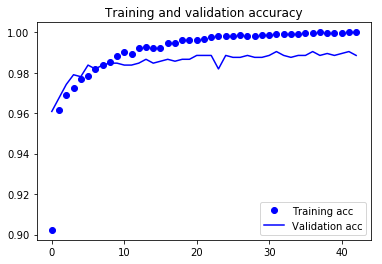

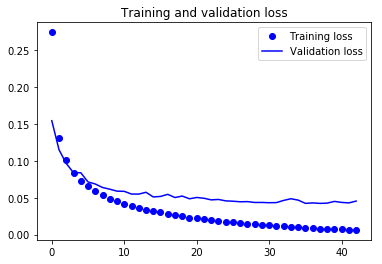

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从训练结果来看，验证集无论是精度还是损失，都在稳步提升。精度最好达到了99%，这几乎是完美的拟合模型。让我们在测试集上看下结果。

H:\Program Files\Anaconda3\envs\tensorflow_gpu\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Found 624 images belonging to 2 classes.
20/20 [==============================] - 9s 456ms/step


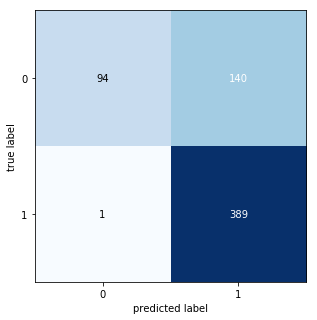

accuracy is 0.7740:
recall is 0.9974:
precision is 0.7353:
F1 score is 0.8466:


In [58]:
from keras.models import load_model
model = load_model('H:/kaggle/chest_xray_shuffle/best_model.h5')

test_generator = test_datagen.flow_from_directory(
        raw_test_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle=False,
        class_mode='binary')

y_pred_base = model.predict_generator(test_generator, verbose=1, steps=ceil(len(raw_test)/32))
y_pred = np.array([1 if y_pred_base[i] > 0.5 else 0 for i in range(len(y_pred_base))])
y_label = np.array(raw_test['label'].values)
CM = confusion_matrix(y_label, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

recall = recall_score(y_label, y_pred)
precision = precision_score(y_label, y_pred)
print('accuracy is %.4f:'% (accuracy_score(y_label, y_pred)))
print('recall is %.4f:' % (recall))
print('precision is %.4f:'% (precision))
print('F1 score is %.4f:'% (2*recall*precision/(recall+precision)))

结果让人非常惊讶，精度只有77%。查全率高达99.7%，而查准率只有73%。<br>
这意味着大量正常样本被误判为肺炎样本，这与验证集的训练结果相差很大。<br>
这里推测原因有两点，一是训练集与测试集样本分布不均衡造成的，这里无法验证；二是样本正反比不均衡。<br>
虽然之前的验证精度很高，但若训练与测试的样本不均衡的话，不排除过拟合问题的存在。

### Augmentation or Not

既然提出过拟合的假设，那么自然考虑到数据增强的方法来验证，同时在模型中增加一层dropout 层。让我们拭目以待。

In [29]:
train_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

train_generator = train_augmentation.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

Found 4185 images belonging to 2 classes.


In [30]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [31]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='H:/kaggle/chest_xray_shuffle/best_model_augmentation.h5', 
                        save_best_only=True)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=ceil(len(train_data)/32),
      epochs=100,
      validation_data=val_generator,
      validation_steps=ceil(len(val_data)/32),
      callbacks=[es, chkpt])

Epoch 1/100
131/131 [==============================] - 118s 905ms/step - loss: 0.4563 - acc: 0.7768 - val_loss: 0.2661 - val_acc: 0.9217
Epoch 2/100
131/131 [==============================] - 124s 944ms/step - loss: 0.2974 - acc: 0.8701 - val_loss: 0.2123 - val_acc: 0.9303
Epoch 3/100
131/131 [==============================] - 111s 844ms/step - loss: 0.2602 - acc: 0.8932 - val_loss: 0.2024 - val_acc: 0.9322
Epoch 4/100
131/131 [==============================] - 110s 837ms/step - loss: 0.2347 - acc: 0.9033 - val_loss: 0.1737 - val_acc: 0.9417
Epoch 5/100
131/131 [==============================] - 110s 841ms/step - loss: 0.2180 - acc: 0.9114 - val_loss: 0.1855 - val_acc: 0.9322
Epoch 6/100
131/131 [==============================] - 110s 838ms/step - loss: 0.2082 - acc: 0.9171 - val_loss: 0.1557 - val_acc: 0.9456
Epoch 7/100
131/131 [==============================] - 109s 832ms/step - loss: 0.2031 - acc: 0.9231 - val_loss: 0.1785 - val_acc: 0.9389
Epoch 8/100
131/131 [====================

Found 624 images belonging to 2 classes.
20/20 [==============================] - 9s 442ms/step


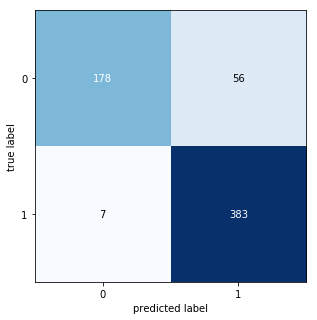

In [34]:
test_generator = test_datagen.flow_from_directory(
        raw_test_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle=False,
        class_mode='binary')

y_pred_base = model.predict_generator(test_generator, verbose=1, steps=ceil(len(raw_test)/32))
y_pred = np.array([1 if y_pred_base[i] > 0.5 else 0 for i in range(len(y_pred_base))])
y_label = np.array(raw_test['label'].values)
CM = confusion_matrix(y_label, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [35]:
recall = recall_score(y_label, y_pred)
precision = precision_score(y_label, y_pred)
print('accuracy is %.4f:'% (accuracy_score(y_label, y_pred)))
print('recall is %.4f:' % (recall))
print('precision is %.4f:'% (precision))
print('F1 score is %.4f:'% (2*recall*precision/(recall+precision)))

accuracy is 0.8990:
recall is 0.9821:
precision is 0.8724:
F1 score is 0.9240:


结果是肯定的，至少在这个样本集上，使用数据增强后，精度提升到了89%，同时查全率几乎没变，这是个好消息。

### Finetune or Not

接下来让我们再试试模型微调，考虑到VGG16 模型训练的高级特征几乎和 X光图片没什么关系，这似乎看上去是个有价值的尝试。

In [64]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 13,502,465
Non-trainable params: 7,635,264
_________________________________________________________________


In [65]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

es = EarlyStopping(patience=10)
chkpt = ModelCheckpoint(filepath='H:/kaggle/chest_xray_shuffle/best_model_augmentation_finetune.h5', 
                        save_best_only=True)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=ceil(len(train_data)/32),
      epochs=100,
      validation_data=val_generator,
      validation_steps=ceil(len(val_data)/32),
      callbacks=[es, chkpt])

Epoch 1/100
131/131 [==============================] - 133s 1s/step - loss: 0.3780 - acc: 0.8216 - val_loss: 0.2011 - val_acc: 0.9236
Epoch 2/100
131/131 [==============================] - 128s 975ms/step - loss: 0.2028 - acc: 0.9160 - val_loss: 0.1187 - val_acc: 0.9618
Epoch 3/100
131/131 [==============================] - 124s 949ms/step - loss: 0.1728 - acc: 0.9297 - val_loss: 0.1198 - val_acc: 0.9503
Epoch 4/100
131/131 [==============================] - 124s 947ms/step - loss: 0.1480 - acc: 0.9435 - val_loss: 0.2128 - val_acc: 0.9131
Epoch 5/100
131/131 [==============================] - 124s 949ms/step - loss: 0.1292 - acc: 0.9518 - val_loss: 0.1662 - val_acc: 0.9312
Epoch 6/100
131/131 [==============================] - 127s 968ms/step - loss: 0.1124 - acc: 0.9556 - val_loss: 0.1088 - val_acc: 0.9599
Epoch 7/100
131/131 [==============================] - 125s 952ms/step - loss: 0.1083 - acc: 0.9610 - val_loss: 0.2114 - val_acc: 0.9121
Epoch 8/100
131/131 [=======================

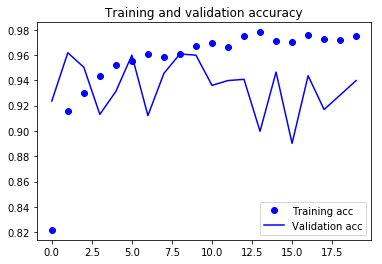

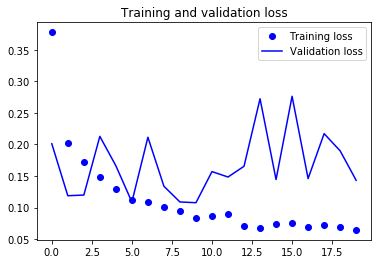

In [66]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Found 624 images belonging to 2 classes.
20/20 [==============================] - 9s 441ms/step


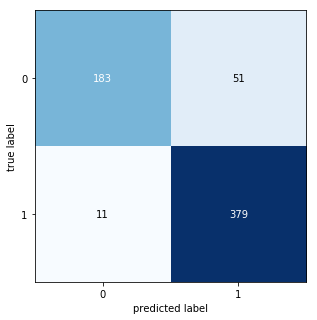

In [67]:
test_generator = test_datagen.flow_from_directory(
        raw_test_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle=False,
        class_mode='binary')

y_pred_base = model.predict_generator(test_generator, verbose=1, steps=ceil(len(raw_test)/32))
y_pred = np.array([1 if y_pred_base[i] > 0.5 else 0 for i in range(len(y_pred_base))])
y_label = np.array(raw_test['label'].values)
CM = confusion_matrix(y_label, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [68]:
recall = recall_score(y_label, y_pred)
precision = precision_score(y_label, y_pred)
print('accuracy is %.4f:'% (accuracy_score(y_label, y_pred)))
print('recall is %.4f:' % (recall))
print('precision is %.4f:'% (precision))
print('F1 score is %.4f:'% (2*recall*precision/(recall+precision)))

accuracy is 0.9006:
recall is 0.9718:
precision is 0.8814:
F1 score is 0.9244:


由于验证损失的不稳定，训练过程很早就结束了。从结果上来看，微调模型虽然增加了训练参数，但并没有换来期待的好的结果。<br>
这里推测的原因是二分类X光图像问题的特征差距不是很复杂，同时也不是很明显。

### Improve Direction

接下来，可以从不同方向进行尝试，比如调整验证集随机参数，调整训练模型以及模型训练参数，增加训练轮数等等。<br>
但这里我们想继续分析下错误样本，看看能不能有所发现。

In [8]:
wrong_label = pd.DataFrame(y_pred == y_label)
wrong_imgs = raw_test.loc[~wrong_label[0]]

这里选取其中30个错误样本

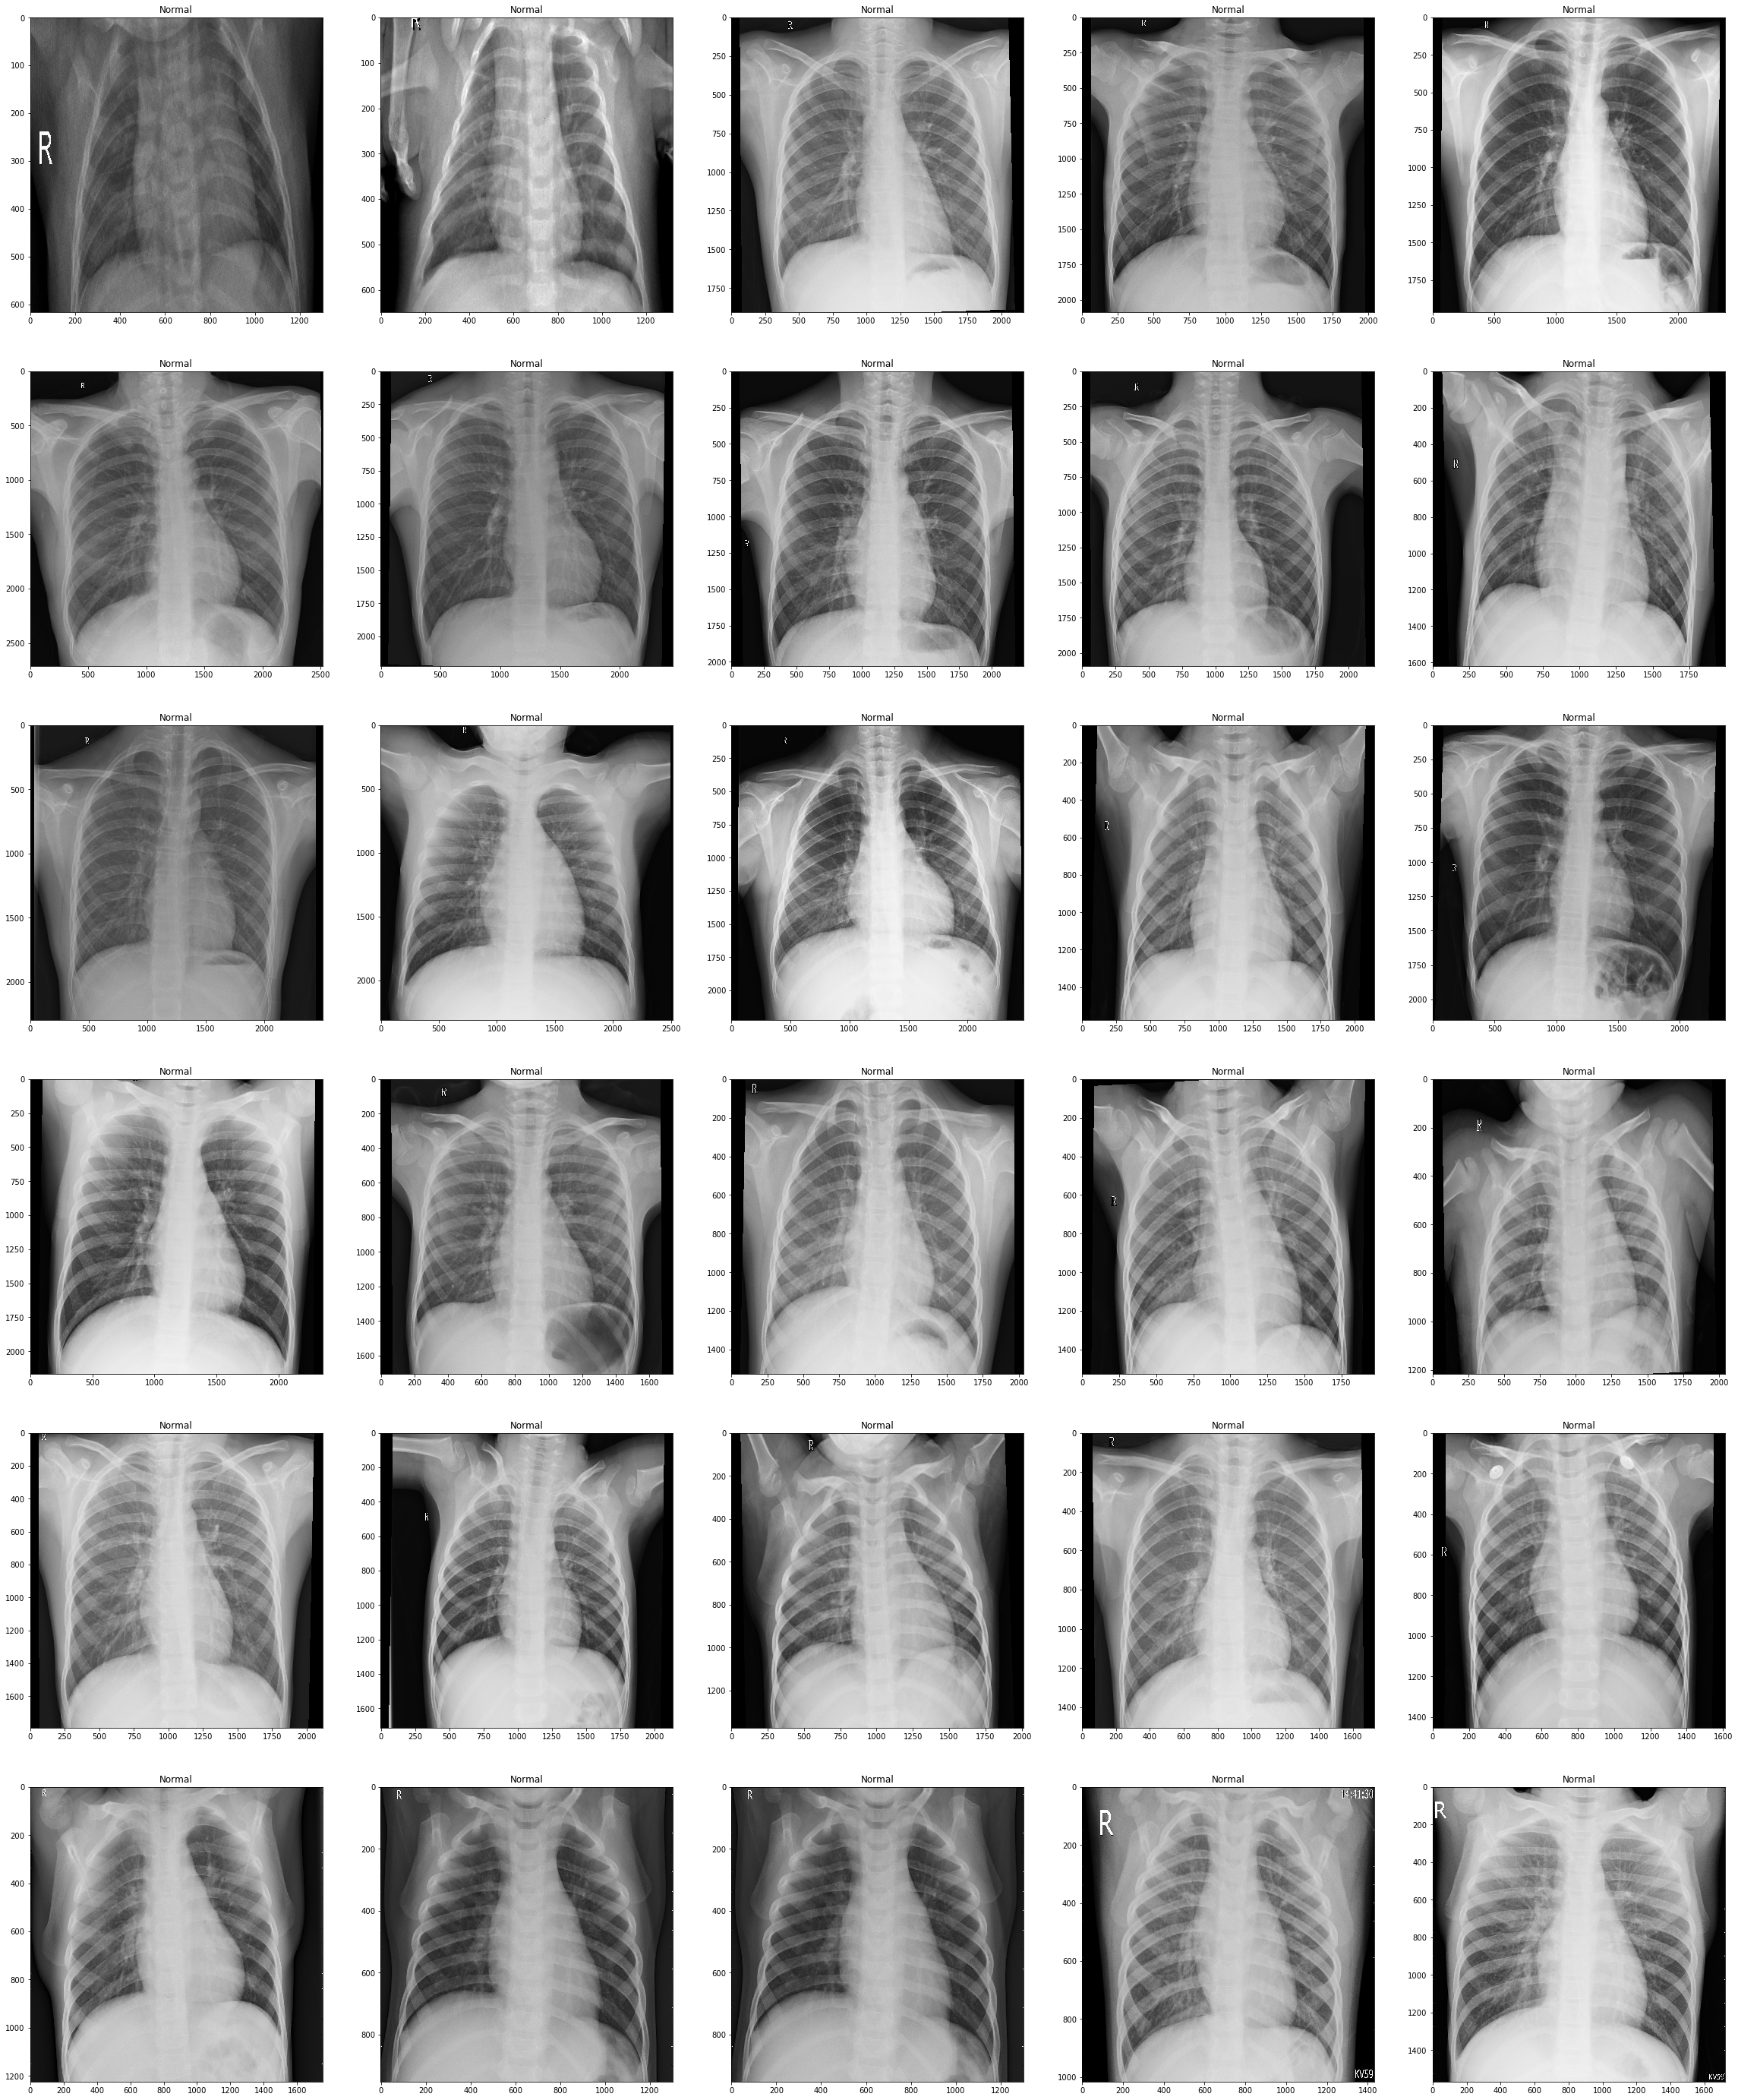

In [11]:
f, ax = plt.subplots(6, 5, figsize=(40, 50))
for i in range(30):
    img = cv2.imread(str(wrong_imgs.iloc[i]['image']), 1)
    ax[i//5, i%5].imshow(img, cmap='gray')
    if wrong_imgs.iloc[i]['label'] == 0:
        ax[i//5, i%5].set_title('Normal')
    else:
        ax[i//5, i%5].set_title('Pneumonia')
        ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

简单看一下，这些图片似乎存在一些可能影响判断的问题。<br>
比如，不少图片上存在一些可以避免的标记:“R”和一些时间记录，这可能会被当成特征来学习。<br>
此外，每张图片的对比度和亮度不太一致，这可能会导致直方图的变化较大，如果可能话，对图片进行预处理可能会使特征学习更准确。

### Summary

- 这个项目的特征学习并不是很复杂，但不同类别的特征差距可能会很细微，这会增加模型训练的困难。<br>
- 训练前，做好均衡样本分布很重要。<br>
- 样本的预处理可能会避免学习错误的特征。<br>